In [1]:
%load_ext autoreload
%autoreload 2

## Stable Diffusion + Multi-plane Synchronization

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Setting up PyTorch plugin "resample_padding_plugin"... 

/home/yukun/.conda/envs/pano/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


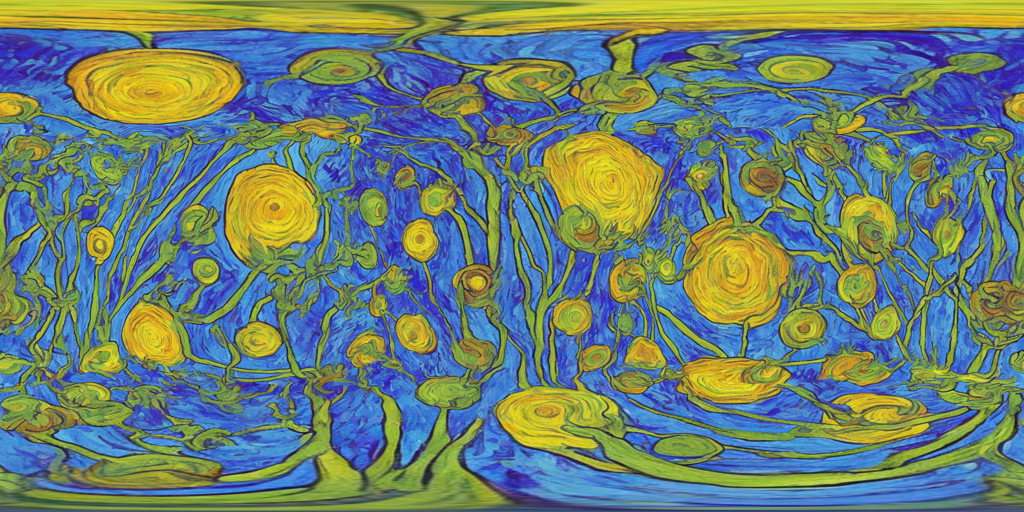

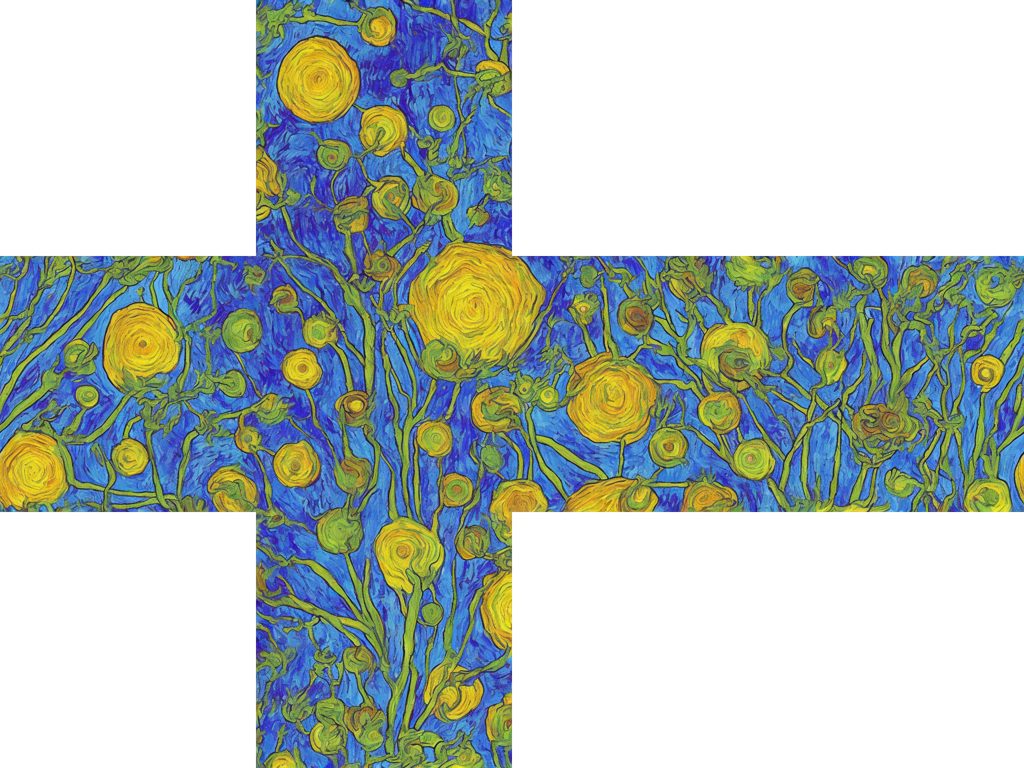

In [2]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
from typing import Optional, Union
from diffusers import StableDiffusionPipeline, DiffusionPipeline, AutoencoderKL

from models.multiplane_sync import apply_custom_processors_for_unet, apply_custom_processors_for_vae
from utils.cube import Cubemap, concat_dice_mask


def images_to_equi_and_dice(
    images: Union[np.ndarray, torch.Tensor],
    equi_height: Optional[int] = None,
    equi_width: Optional[int] = None,
    impl: str = 'crop',
):
    """
    Args:
        images: np.ndarray (B, 6, H, W, C) | torch.Tensor (B, 6, C, H, W)
    Returns:
        equis: np.ndarray, (B, H, W, C)
        dices: np.ndarray, (B, H, W, C)
    """
    if isinstance(images, torch.Tensor):
        images = rearrange(images.cpu().numpy(), '... c h w -> ... h w c')
    
    if equi_height is None:
        equi_height = images.shape[-3] * 2
    
    if equi_width is None:
        equi_width = images.shape[-2] * 4
    
    equis, dices = [], []
    for views in images:
        assert len(views) == 6, "Expected 6 views for cubemap representation"
        if impl == 'pers':
            fovs = np.array([90.0] * 6, dtype=np.float32)
            thetas = np.array([0.0, 90.0, 180.0, 270.0, 0.0, 0.0], dtype=np.float32)
            phis = np.array([0.0, 0.0, 0.0, 0.0, 90.0, -90.0], dtype=np.float32)
            cubemap = Cubemap.from_perspective(views, fovs=fovs, thetas=thetas, phis=phis)
        else:
            cubemap = Cubemap.from_cubediffusion(views, 'list')
        dice = cubemap.cube_all2all(cubemap.faces, cubemap.cube_format, 'dice').astype(images.dtype)
        equi = cubemap.to_equirectangular(h=equi_height, w=equi_width).equirectangular.astype(images.dtype)
        dices.append(dice)
        equis.append(equi)
    
    equis = np.stack(equis, axis=0)  # np.ndarray, (B, H, W, C)
    dices = np.stack(dices, axis=0)  # np.ndarray, (B, H, W, C)

    return equis, dices


def build_sd_pipeline(device, version: str):
    if version == 'sd2':
        pipe = StableDiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-2",
            torch_dtype=torch.float16,
            local_files_only=True,
        )
    
    elif version == 'sdxl':
        pipe = DiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0",
            vae=AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16),
            torch_dtype=torch.float16,
            variant="fp16",
            local_files_only=True,
        )
    
    apply_custom_processors_for_unet(pipe.unet, enable_sync_self_attn=True, enable_sync_cross_attn=False, enable_sync_conv2d=True, enable_sync_gn=True)
    apply_custom_processors_for_vae(pipe.vae, enable_sync_attn=True, enable_sync_gn=True, enable_sync_conv2d=True)
    
    return pipe.to(device)


# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build the Stable Diffusion pipeline with Multi-Plane Sync.
version = 'sd2'  # 'sd2' or 'sdxl'
pipe = build_sd_pipeline(device, version=version)

# Image generation
image_size = 512 if version == 'sd2' else 768
prompts = ["Vast cosmos in the style of Van Gogh"] * 6
latents = torch.randn(6, 4, image_size//8, image_size//8).to(device, dtype=torch.float16)
images = pipe(prompts, latents=latents, output_type='np').images
images = rearrange(images, '(b m) ... -> b m ...', m=6)

# Visualization of generated images
equis, dices = images_to_equi_and_dice(images)
equi_rgb_pil = Image.fromarray((equis[0] * 255).astype(np.uint8))
dice_rgb_pil = Image.fromarray((dices[0] * 255).astype(np.uint8))
equi_rgb_pil.resize((1024, 512)).show()
concat_dice_mask(dice_rgb_pil).resize((1024, 768)).show()


## Marigold + Multi-plane Synchronization

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Marigold predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Diffusion steps...:   0%|          | 0/10 [00:00<?, ?it/s]

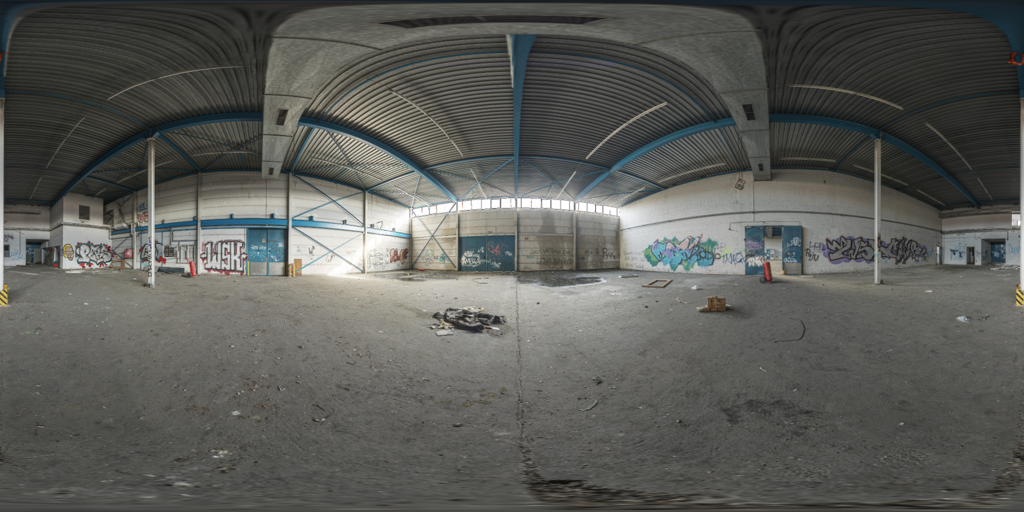

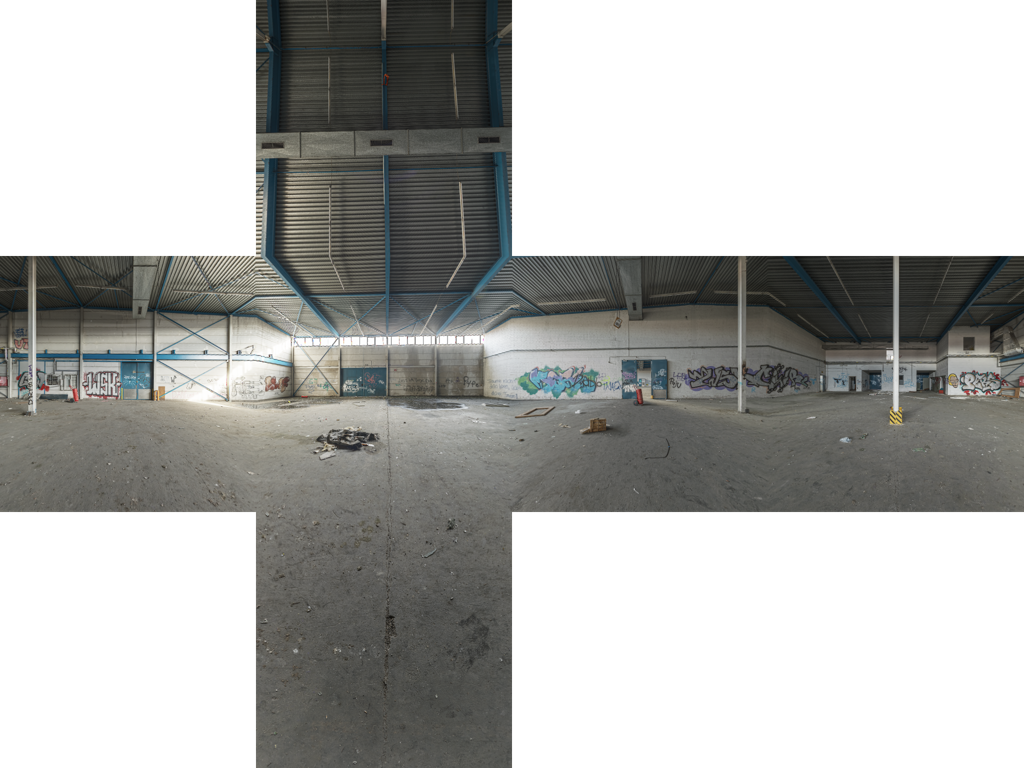

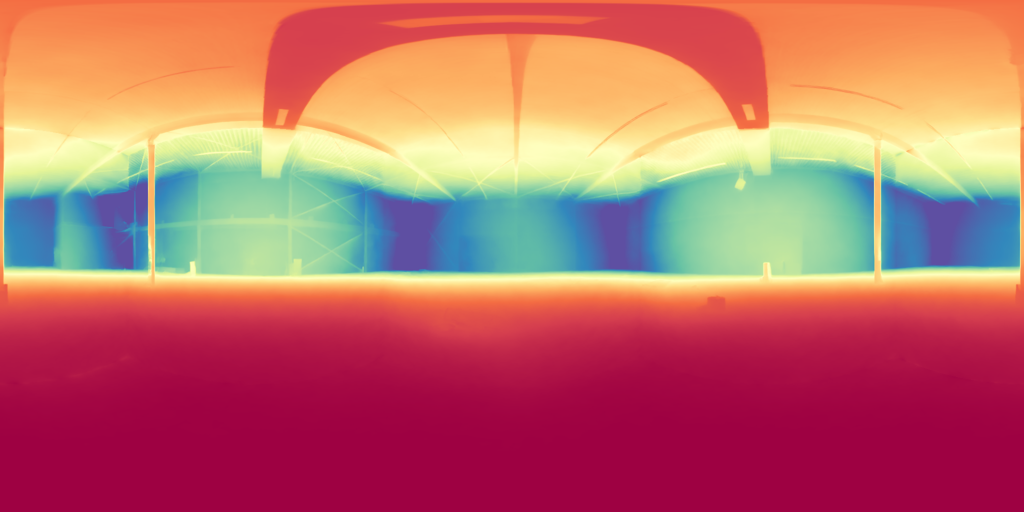

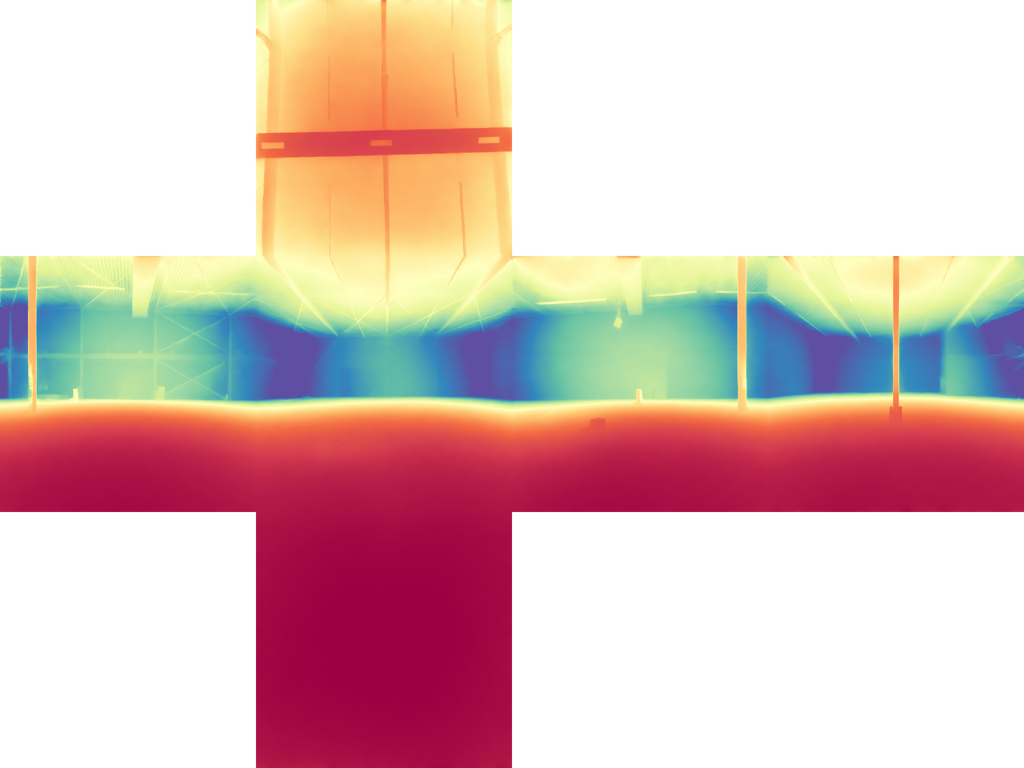

In [3]:
import torch
import numpy as np
from PIL import Image
from einops import rearrange
from typing import Optional, Union
from diffusers.pipelines.marigold.pipeline_marigold_depth import MarigoldDepthPipeline

from models.multiplane_sync import apply_custom_processors_for_unet, apply_custom_processors_for_vae
from utils.cube import Cubemap, concat_dice_mask
from utils.depth import z_distance_to_depth
from utils.equi import Equirectangular


def load_images_from_panorama(pano_path: str, cube_size: int) -> np.ndarray:
    equi = np.array(Image.open(pano_path).convert('RGB'))
    cube = Equirectangular(equi).to_cubemap(cube_size)
    images = Cubemap.cube_all2all_equilib(cube.faces, cube.cube_format, 'list', to_equilib=True)
    images = np.array(images, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    images = rearrange(images, 'm h w c -> 1 m h w c', m=6)
    return images


def images_to_equi_and_dice(
    images: Union[np.ndarray, torch.Tensor],
    equi_height: Optional[int] = None,
    equi_width: Optional[int] = None,
    impl: str = 'crop',
):
    """
    Args:
        images: np.ndarray (B, 6, H, W, C) | torch.Tensor (B, 6, C, H, W)
    Returns:
        equis: np.ndarray, (B, H, W, C)
        dices: np.ndarray, (B, H, W, C)
    """
    if isinstance(images, torch.Tensor):
        images = rearrange(images.cpu().numpy(), '... c h w -> ... h w c')
    
    if equi_height is None:
        equi_height = images.shape[-3] * 2
    
    if equi_width is None:
        equi_width = images.shape[-2] * 4
    
    equis, dices = [], []
    for views in images:
        assert len(views) == 6, "Expected 6 views for cubemap representation"
        if impl == 'pers':
            fovs = np.array([90.0] * 6, dtype=np.float32)
            thetas = np.array([0.0, 90.0, 180.0, 270.0, 0.0, 0.0], dtype=np.float32)
            phis = np.array([0.0, 0.0, 0.0, 0.0, 90.0, -90.0], dtype=np.float32)
            cubemap = Cubemap.from_perspective(views, fovs=fovs, thetas=thetas, phis=phis)
        else:
            cubemap = Cubemap.from_cubediffusion(views, 'list')
        dice = cubemap.cube_all2all(cubemap.faces, cubemap.cube_format, 'dice').astype(images.dtype)
        equi = cubemap.to_equirectangular(h=equi_height, w=equi_width).equirectangular.astype(images.dtype)
        dices.append(dice)
        equis.append(equi)
    
    equis = np.stack(equis, axis=0)  # np.ndarray, (B, H, W, C)
    dices = np.stack(dices, axis=0)  # np.ndarray, (B, H, W, C)

    return equis, dices


def build_marigold_pipeline(device):
    pipe = MarigoldDepthPipeline.from_pretrained(
        'prs-eth/marigold-depth-v1-0',
        variant="fp16",
        torch_dtype=torch.float16,
        local_files_only=True,
    )
    apply_custom_processors_for_unet(pipe.unet, enable_sync_self_attn=True, enable_sync_cross_attn=True, enable_sync_conv2d=True, enable_sync_gn=True)
    apply_custom_processors_for_vae(pipe.vae, enable_sync_attn=True, enable_sync_gn=True, enable_sync_conv2d=True)
    return pipe.to(device)


# Get device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build the Marigold pipeline with Multi-Plane Sync.
pipe = build_marigold_pipeline(device)

# Load cube images from a panorama
images = load_images_from_panorama('assets/abandoned_hall.png', cube_size=512)

# Depth estimation
inputs = rearrange(torch.from_numpy(images), 'b m h w c -> (b m) c h w', m=6).to(device)
depths = pipe(inputs, output_type='np', batch_size=6).prediction
depths = rearrange(depths, '(b m) ... -> b m ...', m=6)
depths = z_distance_to_depth(depths, 90.0, 90.0)

# Visualization of images
equis, dices = images_to_equi_and_dice(images)
equi_rgb_pil = Image.fromarray((equis[0] * 255).astype(np.uint8))
dice_rgb_pil = Image.fromarray((dices[0] * 255).astype(np.uint8))
equi_rgb_pil.resize((1024, 512)).show()
concat_dice_mask(dice_rgb_pil).resize((1024, 768)).show()

# Visualization of depths
val_min, val_max = np.percentile(depths, 2), np.percentile(depths, 98)  # 0.0, 1.0
equis, dices = images_to_equi_and_dice(depths)
equi_depth_vis = pipe.image_processor.visualize_depth(equis, val_min, val_max)[0]
dice_depth_vis = pipe.image_processor.visualize_depth(dices, val_min, val_max)[0]
equi_depth_vis.resize((1024, 512)).show()
concat_dice_mask(dice_depth_vis).resize((1024, 768)).show()
